# pybeach

## A Python package for locating the dune toe on cross-shore beach profile transects.

In [4]:
!git clone --depth=1 https://github.com/TristanSalles/pybeach.git; cd pybeach; python3 setup.py install; cd ..; rm -rf pybeach 

Cloning into 'pybeach'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 101 (delta 3), reused 68 (delta 0), pack-reused 0
Receiving objects: 100% (101/101), 5.77 MiB | 17.74 MiB/s, done.
Resolving deltas: 100% (3/3), done.
running install
running bdist_egg
running egg_info
running build_src
build_src
creating pybeach.egg-info
writing pybeach.egg-info/PKG-INFO
writing dependency_links to pybeach.egg-info/dependency_links.txt
writing requirements to pybeach.egg-info/requires.txt
writing top-level names to pybeach.egg-info/top_level.txt
writing manifest file 'pybeach.egg-info/SOURCES.txt'
reading manifest file 'pybeach.egg-info/SOURCES.txt'
writing manifest file 'pybeach.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/pybeach
copying pybeach/beach.py -> build/li

In [1]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybeach.beach import Profile
from pybeach.support import data_support as ds
from pybeach.support import classifier_support as cs
%matplotlib inline

In [2]:
from pybeach.beach import Profile

# example data
x = np.arange(0, 80, 0.5)
z = np.concatenate((np.linspace(4, 5, 40),
                    np.linspace(5, 2, 10),
                    np.linspace(2, 0, 91)[1:],
                    np.linspace(0, -1, 20)))

# instantiate
p = Profile(x, z)

# predict dune toe, dune crest, shoreline location
toe_ml, prob_ml = p.predict_dunetoe_ml('wave_embayed_clf')  # predict toe using machine learning model
toe_mc = p.predict_dunetoe_mc()    # predict toe using maximum curvature method (Stockdon et al, 2007)
toe_rr = p.predict_dunetoe_rr()    # predict toe using relative relief method (Wernette et al, 2016)
toe_pd = p.predict_dunetoe_pd()    # predict toe using perpendicular distance method
crest = p.predict_dunecrest()      # predict dune crest
shoreline = p.predict_shoreline()  # predict shoreline

/Users/getafix/anaconda3/envs/coast/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/getafix/anaconda3/envs/coast/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/getafix/anaconda3/envs/coast/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fr

In [3]:
from pybeach.beach import Profile
import warnings
warnings.simplefilter("ignore", UserWarning)

# Plotting Paramaters
params = {'legend.fontsize': 12,
           'axes.labelsize': 14,
           'axes.labelweight': 'bold',
           'axes.titlesize': 14,
           'axes.titleweight': 'bold',
           'xtick.labelsize': 14,
           'ytick.labelsize': 14,
           'mathtext.default':'regular'}
plt.rcParams.update(params)

# example data
x = np.arange(0, 80, 0.5)
z = np.concatenate((np.linspace(4, 5, 40),
                    np.linspace(5, 2, 10),
                    np.linspace(2, 0, 91)[1:],
                    np.linspace(0, -1, 20)))

# instantiate
p = Profile(x, z)

In [5]:
# Predict dune toe location
toe_ml = p.predict_dunetoe_ml('wave_embayed_clf') # use the machine learning (ML) method
toe_mc = p.predict_dunetoe_mc() # use the maximum curvature (MC) method
toe_rr = p.predict_dunetoe_rr() # use the relative relief (RR) method
toe_pd = p.predict_dunetoe_pd() # use the perpendicular distance (PD) method

In [6]:
# Predict shoreline and dune crest location
crest = p.predict_dunecrest()
shoreline = p.predict_shoreline()

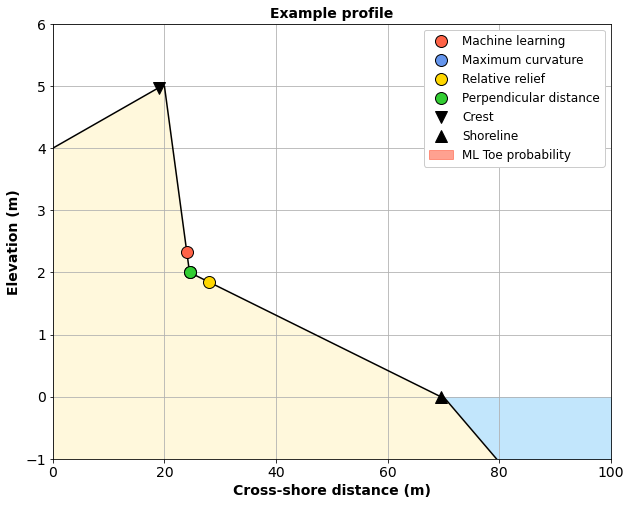

In [7]:
n=0
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
toes = [toe_ml[n], toe_mc[n], toe_rr[n], toe_pd[n]]

labels = ['Machine learning', 'Maximum curvature', 'Relative relief', 'Perpendicular distance']
colors = ['tomato', 'cornflowerblue', 'gold', 'limegreen']

axes.plot(x, z, '-k')
axes.fill_between([70, 100], [0, 0], y2=-1, color='lightskyblue', alpha=0.5)
axes.fill_between(x, z, y2=-1, color='cornsilk', alpha=1)
axes.axvspan(-10, -9, color='tomato', alpha = 0.6, label='ML Toe probability') # legend placeholder
for i, itoe in enumerate(toes): 
    axes.plot(x[itoe], z[itoe],
              'o', color=colors[i], ms=12, mec='k', label=labels[i])
axes.plot(x[crest[n]], z[crest[n]], 'v', color='k', ms=12, mec='k', label='Crest')
axes.plot(x[shoreline[n]], z[shoreline[n]], '^', color='k', ms=12, mec='k', label='Shoreline')
axes.set_xlim(0, 100)
axes.set_ylim(-1, 6)
axes.set_title('Example profile')
axes.set_xlabel('Cross-shore distance (m)')
axes.set_ylabel('Elevation (m)')
axes.grid()
axes.legend(framealpha=1)
fig.show()

## Table of Contents

This notebook demonstrates a few key elements of pybeach, including:
1. [Predicting dune toes](#1)
2. [Example plots and results](#2)

In [ ]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybeach.beach import Profile
from pybeach.support import data_support as ds
from pybeach.support import classifier_support as cs
%matplotlib inline

### Load test data

In [8]:
# Load some test data of 200 profiles
with open('../pracenv/dataset/test_profiles.pkl', 'rb') as f:
    data = pickle.load(f)
x, z, toe = data['x'], data['z'], data['toe']

### 1. Predicting dune toes <a name="1"></a>

In [11]:
# Instantiate Profile class
p = Profile(x, z)
# Make predictions of dune toe
toe_ml, prob_ml = p.predict_dunetoe_ml('barrier_island_clf', dune_crest='rr', window_size=101, threshold=0.97)
toe_mc = p.predict_dunetoe_mc(dune_crest='rr', window_size=101, threshold=0.97)
toe_rr = p.predict_dunetoe_rr(dune_crest='rr', window_size=101, threshold=0.97, toe_threshold=0.2, verbose=False)
toe_pd = p.predict_dunetoe_pd(dune_crest='rr', window_size=101, threshold=0.97)
# Predict dune crest
crest = p.predict_dunecrest()
# Predict shoreline
shoreline = p.predict_shoreline()

### 2. Example plots and results <a name="2"></a>

In [12]:
# Plotting Paramaters
params = {'legend.fontsize': 12,
           'axes.labelsize': 14,
           'axes.labelweight': 'bold',
           'axes.titlesize': 14,
           'axes.titleweight': 'bold',
           'xtick.labelsize': 14,
           'ytick.labelsize': 14,
           'mathtext.default':'regular'}
plt.rcParams.update(params)

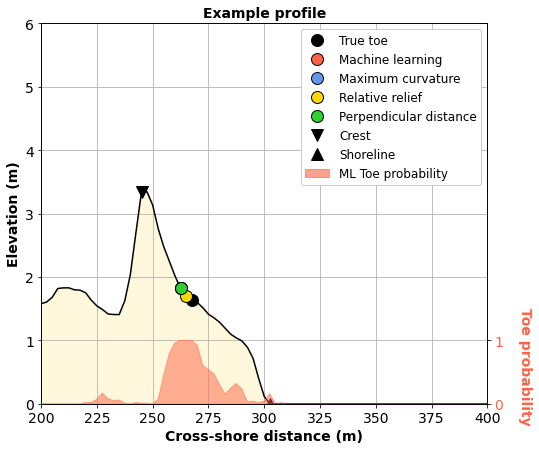

In [20]:
# Specify profile to plot
n = 0
# Figure metadata
fig, axes = plt.subplots(1, 1, figsize=(8, 7))
toes = [toe[n], toe_ml[n], toe_mc[n], toe_rr[n], toe_pd[n]]
labels = ['True toe', 'Machine learning', 'Maximum curvature', 'Relative relief', 'Perpendicular distance']
colors = ['k', 'tomato', 'cornflowerblue', 'gold', 'limegreen']
# Generate figure
axes.plot(x, z[n], '-k')
axes.fill_between([70, 100], [0, 0], y2=-1, color='lightskyblue', alpha=0.5)
axes.fill_between(x, z[n], y2=-1, color='cornsilk', alpha=1)
axes.axvspan(-10, -9, color='tomato', alpha = 0.6, label='ML Toe probability') # legend placeholder
for i, itoe in enumerate(toes): 
    axes.plot(x[itoe], z[n, itoe],
              'o', color=colors[i], ms=12, mec='k', label=labels[i])
axes.plot(x[crest[n]], z[n, crest[n]], 'v', color='k', ms=12, mec='k', label='Crest')
axes.plot(x[shoreline[n]], z[n, shoreline[n]], '^', color='k', ms=12, mec='k', label='Shoreline')
axes.set_xlim(200, 400)
axes.set_ylim(0, 6)
axes.set_title('Example profile')
axes.set_xlabel('Cross-shore distance (m)')
axes.set_ylabel('Elevation (m)')
axes.grid()
axes.legend(framealpha=1)
# Plot dune toe ML probability
axes2 = axes.twinx() 
axes2.fill_between(x, prob_ml[n], color='tomato', alpha=0.5)
axes2.set_ylim(0, 6)
axes2.set_yticks([0, 1])
axes2.tick_params(axis='y', labelcolor='tomato')
axes2.yaxis.set_label_coords(1.1, 0.1)
axes2.set_ylabel('Toe probability', color='tomato', rotation=270);

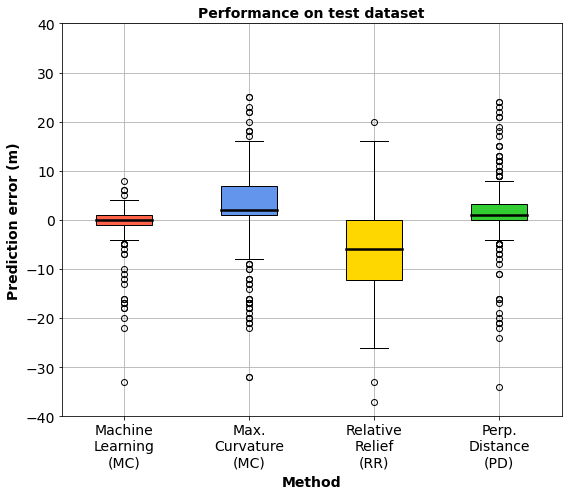

In [21]:
# Figure metadata
fig, axes = plt.subplots(1, 1, figsize=(8,7))
colors = ['tomato', 'cornflowerblue', 'gold', 'limegreen']
labels = ['Machine\nLearning\n(MC)', 'Max.\nCurvature\n(MC)', 'Relative\nRelief\n(RR)', 'Perp.\nDistance\n(PD)']
# Generate figure
data = (toe - np.vstack((toe_ml, toe_mc, toe_rr, toe_pd))).T.astype("float64")
# data1[:,2] *= 0.7
bplot = axes.boxplot(data,
                     labels=labels,
                     patch_artist=True,
                     medianprops = dict(linewidth=2.5, color='k'))
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
axes.set_ylabel('Prediction error (m)')
axes.set_xlabel('Method', labelpad=5)
axes.set_ylim(-40, 40)
axes.grid()
axes.set_title("Performance on test dataset")
plt.tight_layout()

In [15]:
df = pd.DataFrame({'MAE': [np.absolute(toe-toe_ml).mean(),
                           np.absolute(toe-toe_mc).mean(),
                           np.absolute(toe-toe_rr).mean(),
                           np.absolute(toe-toe_pd).mean()],
                   'RMSE': [np.sqrt(np.square(toe-toe_ml).mean()),
                            np.sqrt(np.square(toe-toe_mc).mean()),
                            np.sqrt(np.square(toe-toe_rr).mean()),
                            np.sqrt(np.square(toe-toe_pd).mean())],
                   'R2': [1 - (np.square(toe-toe_ml)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_mc)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_rr)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_pd)).sum() / (np.square(toe-toe.mean())).sum()]},
                  index=['ML', 'MC', 'RR', 'PD']).round(2)
df

,MAE,RMSE,R2
ML,2.40,5.17,0.99
MC,7.59,10.57,0.96
RR,8.59,11.22,0.95
PD,5.18,8.22,0.98
